Information recovery from unlabled DNA reads by k-mer density. K-means and dot product similarity clustering

currently geared towards ultra long nanopore reads

In [13]:
import sys
import random
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import itertools
import plotly.express as px
import numpy as np
from scipy.stats import truncnorm
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.vq import kmeans2, vq
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


import gc
import torch

from tqdm import tqdm


import torch
from transformers import AutoTokenizer, AutoModel, BertConfig


In [10]:

# Written by: David Bernick
class FastAreader:
    '''
    Define objects to read FastA files.

    instantiation:
    thisReader = FastAreader ('testTiny.fa')
    usage:
    for head, seq in thisReader.readFasta():
        print (head,seq)
    '''

    def __init__(self, fname=None):
        '''contructor: saves attribute fname '''
        self.fname = fname

    def doOpen(self):
        ''' Handle file opens, allowing STDIN.'''
        if self.fname is None:
            return sys.stdin
        else:
            return open(self.fname)

    def readFasta(self):
        ''' Read an entire FastA record and return the sequence header/sequence'''
        header = ''
        sequence = ''

        with self.doOpen() as fileH:

            header = ''
            sequence = ''

            # skip to first fasta header
            line = fileH.readline()
            while not line.startswith('>'):
                line = fileH.readline()
            header = line[1:].rstrip()

            for line in fileH:
                if line.startswith('>'):
                    yield header, sequence
                    header = line[1:].rstrip()
                    sequence = ''
                else:
                    sequence += ''.join(line.rstrip().split()).upper()

        yield header, sequence


In [4]:


'''
For dev purposes only

Given genome files in fasta format, break this up into "reads" of random lengths 
between 50kb and 1mb, aiming for ~30x coverage. This is to simulate the reads that
would be generated by a nanopore sequencer, given a complete genome assembly. These
"reads" will be mixed in with another set of "reads" of another organism. these "reads"
 will go into one output file in fasta format, with unique identifiers
'''

class ReadMaker:
    def __init__(self, genome_paths, coverage, lenRange):
        self.head = []
        self.seq = []
        for path in genome_paths:
            head, seq = self.read_genome(path)
            self.head.append(head)
            self.seq.append(seq)

        self.coverage = coverage
        self.lenRange = lenRange

        self.lengths = []


    def read_genome(self, genome_path):
        thisReader = FastAreader(genome_path)

        for head, seq in thisReader.readFasta():
            head = head.replace(',', '_')
            return head, seq
        
    '''
    #def read_lengths(self):
        #l = 180000 #~
        #shape = 1  # Adjust this to control the skewness of the distribution
        #scale = l / shape  # Adjust this to control the spread of the distribution
        # Generate the values
        #return int(l + random.gammavariate(shape, scale))
        #return int(l + random.expovariate(1/l)) 
    '''
        
    def read_lengths(self, mu, sigma, min_val, max_val):
        # Set the parameters
        mu = np.log(mu)  # The mean of the log of the distribution
        min_val = np.log(min_val)
        max_val = np.log(max_val)

        # Generate the values
        a, b = (min_val - mu) / sigma, (max_val - mu) / sigma  # Calculate the truncated range

        value = 0
        while value < 35000:
            value = np.exp(truncnorm.rvs(a, b, loc=mu, scale=sigma))
            
        # Convert the value to an integer
        value = int(value)

        return value

    def make_reads(self):
        '''
        generate reads from the genome

        Determine read length with random.randint between s, l (lenRange) and extract read from the begaining of genome,
        then remove that read from the genome. Repeat until genome is empty. When the readlength is greater than the 
        remaining genome length, extract the remaining genome as the last read. 

        Reades should be directly written/added to a file (called testReads.txt) in fasta format (read name given on a line begainning with >, 
        sequence beneath.) Each read should be given a unique name, by appending a number to the base name for the genome.
        
        right now the final snippet can be trunicated to very short read
        '''
        counter = 0
        s, l = self.lenRange

        mu = 5000  # The mean of the log of the distribution
        sigma = 2  # The standard deviation of the log of the distribution
        min_val = 11000 
        max_val = 500000
        # head = self.head # base name for genome

        num_genomes = len(self.seq)
        

        with open('testReads.txt', 'w') as f:
            for num in range(num_genomes):  # for each genome
                for i in range(self.coverage):
                    # raw python string of genome sequence
                    genome = self.seq[num]
                    head = self.head[num]
                    while genome:
                        # Generate a random number with an exponential distribution skewed towards lower read lengths
                        read_len = self.read_lengths(mu, sigma, min_val, max_val)
                        self.lengths.append(read_len)
                        read = genome[:read_len]
                        counter += 1
                        
                        
                        f.write(f'>{head}_{counter}_{len(read)}\n{read}\n')
                        genome = genome[read_len:]
        

    def plot_results(self):
        results = self.lengths
        # Create a histogram of the results
        plt.hist(results, bins=50, edgecolor='black')

        # Calculate statistics
        min_val = min(results)
        max_val = max(results)
        mean_val = np.mean(results)
        median_val = np.median(results)

        # Display the plot with statistics
        plt.text(0.95, 0.95, f'Min: {min_val}\nMax: {max_val}\nMean: {mean_val:.2f}\nMedian: {median_val:.2f}',
            horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

        # Add title to the plot
        plt.title("Read Length Distribution")
        
        plt.show()



In [24]:

class featureExtraction:
    def __init__(self, path):
        thisReader=FastAreader(path)
        self.heads = []
        self.seqs = []

        for head, seq in thisReader.readFasta():
            self.heads.append(head)
            self.seqs.append(seq)

        # permutations of DNA 4-mers
        self.fourMers = [''.join(p) for p in itertools.product('ACGT', repeat=4)]


        self.tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
        self.model = AutoModel.from_config(config)
        
    def data_output(self):
        return self.head, self.seq

    def parse_head(self, s):
        # headers -h
        part1 = s.split(' ', 1)[1]
        part1 = part1.split('_', 1)[0]
        part2 = s.rsplit('_', 1)[1]
        return f'{part1} {part2}'

    def fourMerProfile(self, outPath):
        '''
        We have self.fourMers, a list of all possible 4-mers. We also have a list self.heads, and a list self.seqs.
        This method will write to file 'testProfiles.csv' the read name and the kmer frequency profile. The CSV will
        have a column for the read name, and a column for each 4-mer. The values will be the read name and frequency 
        of each 4-mer (with overlap). EG. if the read is "AGTCT", then the 4-mers present are "AGTC", "GTCT".

        for each read, determine the count of all 4-mers.
        '''
        with open(outPath, 'w') as file:
            file.write('Read Name,')
            file.write(','.join(self.fourMers))
            file.write('\n')
            for i in range(len(self.heads)):
                read_name = self.parse_head(self.heads[i])
                kmer_freq = [str(self.seqs[i].count(kmer) / (len(self.seqs[i])-3)) for kmer in self.fourMers]
                file.write(read_name + ',')
                file.write(','.join(kmer_freq))
                file.write('\n')

    def tokenProfile(self, toks, outPath):
        '''
        This method will write to file 'testProfiles.csv' the read name and the token frequency profile. The CSV will
        have a column for the read name, and a column for each token. The values will be the read name and frequency 
        of each token (with overlap).

        for each read, determine the count of all tokens.
        '''
        with open(outPath, 'w') as file:
            file.write('Read Name,')
            file.write(','.join(toks))
            file.write('\n')
            for i in range(len(self.heads)):
                read_name = self.parse_head(self.heads[i])
                token_freq = [str(self.seqs[i].count(token) / (len(self.seqs[i])-len(token)+1)) for token in toks]
                file.write(read_name + ',')
                file.write(','.join(token_freq))
                file.write('\n')
                
    def dnaBertEmbedding(self, outPath):
        window_size = 2000
        step_size = 1000

        with open(outPath, 'w') as file:
            file.write('Read Name,')
            file.write(','.join(['Dimension ' + str(i) for i in range(768)]))  # Assuming the embedding dimension is 768
            file.write('\n')

            for i in range(len(self.heads)):
                read_name = self.parse_head(self.heads[i])
                dna = self.seqs[i]

                embeddings = []

                for j in range(0, len(dna) - window_size + 1, step_size):
                    window = dna[j:j + window_size]
                    with torch.no_grad():  # Disable gradient calculatio2
                        inputs = self.tokenizer(window, return_tensors='pt')["input_ids"]
                        hidden_states = self.model(inputs)[0]  # [1, sequence_length, 768]

                        embedding_mean = torch.mean(hidden_states[0], dim=0)
                        embeddings.append(embedding_mean)

                    # Delete variables and manually run garbage collector
                    del inputs
                    del hidden_states
                    gc.collect()

                embedding = torch.mean(torch.stack(embeddings), dim=0)

                file.write(read_name + ',')
                file.write(','.join([str(value.item()) for value in embedding]))
                file.write('\n')

                # Delete variables and manually run garbage collector after each sequence
                del embeddings
                del embedding
                gc.collect()

    def get_unique_tokens(self):
        window_size = 2000
        step_size = 1000

        unique_tokens = set()

        # Wrap your iterable with tqdm()
        for i in tqdm(range(len(self.heads)), desc="Processing sequences"):
            dna = self.seqs[i]

            for j in range(0, len(dna) - window_size + 1, step_size):
                window = dna[j:j + window_size]
                inputs = self.tokenizer(window, return_tensors='pt')["input_ids"]

                # Convert token IDs back to tokens and add them to the set
                tokens = self.tokenizer.convert_ids_to_tokens(inputs[0])
                unique_tokens.update(tokens)

        return unique_tokens

In [27]:

def kMeansElbow(fName):
    df = pd.read_csv(fName)
    names = df['Read Name'].reset_index(drop=True) #<--?
    df = df.drop(columns=['Read Name'])

    # Elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
def kMeans(fName, n_clusters):
    df = pd.read_csv(fName)
    names = df['Read Name'].reset_index(drop=True)
    df = df.drop(columns=['Read Name'])

    # Run KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(df)

    # Reduce the data to 2 dimensions using PCA for plotting
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)

    # Transform the cluster centers
    cluster_centers_2d = pca.transform(kmeans.cluster_centers_)

    # Create DataFrame for plotting
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    # Add the cluster labels to the DataFrame
    principalDf['cluster'] = pred_y

    # Create an interactive scatter plot with hover labels
    fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color='cluster', hover_data=[names])

    # Add the cluster centers to the plot
    fig.add_trace(go.Scatter(x=cluster_centers_2d[:, 0], y=cluster_centers_2d[:, 1], mode='markers', marker=dict(size=12, color='Red')))

    fig.update_layout(title_text="kMeans++ (4-Mer Density)")
    fig.show()
    return principalDf

from plotly.graph_objs import Scatter3d

def tDkMeans(fName, n_clusters):
    df = pd.read_csv(fName)
    names = df['Read Name'].reset_index(drop=True)
    df = df.drop(columns=['Read Name'])

    # Run KMeans with the optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(df)

    # Reduce the data to 3 dimensions using PCA for plotting
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(df)

    # Transform the cluster centers
    cluster_centers_3d = pca.transform(kmeans.cluster_centers_)

    # Create DataFrame for plotting
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

    # Add the cluster labels to the DataFrame
    principalDf['cluster'] = pred_y

    # Create an interactive scatter plot with hover labels
    fig = px.scatter_3d(principalDf, x='principal component 1', y='principal component 2', z='principal component 3', color='cluster', hover_data=[names])

    # Add the cluster centers to the plot
    fig.add_trace(Scatter3d(x=cluster_centers_3d[:, 0], y=cluster_centers_3d[:, 1], z=cluster_centers_3d[:, 2], mode='markers', marker=dict(size=12, color='Red')))

    fig.update_layout(title_text="kMeans++ (4-Mer Density)")
    fig.show()
    return principalDf

def cluster_with_cosine_similarity(fName, n_clusters):
    df = pd.read_csv(fName)
    read_names = df['Read Name']
    df = df.drop(columns=['Read Name'])
    # Use AgglomerativeClustering with cosine linkage
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    labels = clustering.fit_predict(df)
    # Reduce the data to 2 dimensions using PCA for plotting
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    # Create DataFrame for plotting
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    # Add the labels and read names to the DataFrame
    principalDf['label'] = labels.astype(str)  # Convert labels to string type
    principalDf['Read Name'] = read_names
    # Create a scatter plot of the clusters
    fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color='label',
                     hover_data=['Read Name'], color_discrete_sequence=px.colors.qualitative.Dark24)
    # Add title to the graph
    fig.update_layout(title_text="Cosine Sim .(4-Mer Density)")
    fig.show()


def dbscan(fName, eps=0.5, min_samples=5):
    df = pd.read_csv(fName)
    names = df['Read Name'].reset_index(drop=True)
    df = df.drop(columns=['Read Name'])

    # Standardize the features to have mean=0 and variance=1
    X_std = StandardScaler().fit_transform(df)

    # Run DBSCAN on the data
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_std)
    labels = db.labels_

    # Reduce the data to 2 dimensions using PCA for plotting
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X_std)

    # Create DataFrame for plotting
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    # Add the cluster labels to the DataFrame
    principalDf['cluster'] = labels.astype(str)  # Convert labels to string type

    # Create an interactive scatter plot with hover labels
    fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color='cluster', hover_data=[names], color_discrete_sequence=px.colors.qualitative.Dark24)

    fig.update_layout(title_text="DBSCAN (4-Mer Density)")
    fig.show()




def true_clusters(fName):
    df = pd.read_csv(fName)
    names = df['Read Name'].reset_index(drop=True)
    df = df.drop(columns=['Read Name'])

    # Extract the first word from the names
    first_words = [name.split(' ')[0] for name in names]

    # Reduce the data to 2 dimensions using PCA for plotting
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)

    # Create DataFrame for plotting
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    # Add the first words to the DataFrame
    principalDf['first_word'] = first_words

    # Create an interactive scatter plot with hover labels
    fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color='first_word', hover_data=[names])

    fig.update_layout(title_text="True Clusters .(4-Mer Density)")
    fig.show()


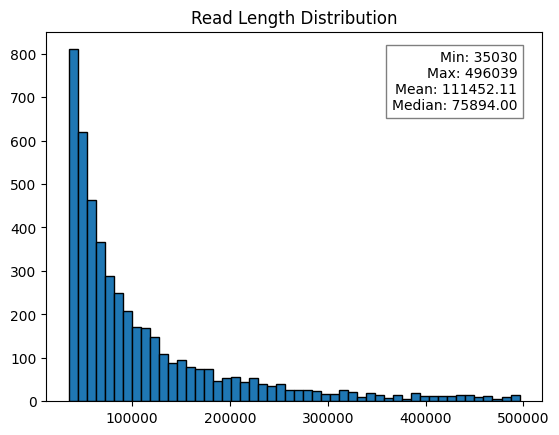

In [51]:
# generate Data
def main():
    genome_paths = ['/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/EC_GCF_ASM584v2_genomic.txt', 
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/MC_GCF_001578075.1_ASM157807v1_genomic.txt',
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/GCF_000317695.1_ASM31769v1_genomic.txt', 
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/GCF_000146045.2_R64_genomic.txt',
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/GCF_020138775.1_ASM2013877v1_genomic.txt',
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/GCF_012516395.1_ASM1251639v1_genomic.txt',
                    '/Users/jlarbale/Desktop/clusterKdata/Genomes/Assembly/GCF_020162255.1_ASM2016225v1_genomic.txt'
                    ]
    coverage = 20
    lenRange = (50000, 1000000) 
    readMaker = ReadMaker(genome_paths, coverage, lenRange) # shreds genome into reads, length between 50kb and 1mb with L~exp(x)
    readMaker.make_reads()
    readMaker.plot_results()

    

    readPath = '/Users/jlarbale/Desktop/clusterKdata/codeBase/testReads.txt'
    extractFeatures = featureExtraction(readPath)
    extractFeatures.fourMerProfile('testProfiles.csv')

    global heads, seqs
    heads, seqs = extractFeatures.data_output()

if __name__ == '__main__':
    main()

In [25]:
extractFeatures = featureExtraction('testReads.txt')
toks = extractFeatures.get_unique_tokens()
print(len(toks))

Processing sequences:   1%|          | 24/4779 [00:03<10:50,  7.32it/s]


KeyboardInterrupt: 

In [26]:
extractFeatures.tokenProfile(toks, 'testTOKProfiles.csv')

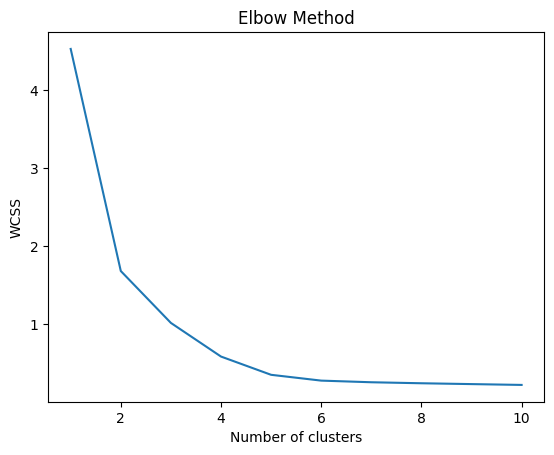

/Users/jlarbale/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [52]:
kMeansElbow('testProfiles.csv') # fName
data = kMeans('testProfiles.csv', 7) # fName, n_clusters
true_clusters('testProfiles.csv') # fName

In [28]:
cluster_with_cosine_similarity('testProfiles.csv', 7) # fName, n_clusters
tDkMeans('testProfiles.csv', 7) # fName, n_clusters

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/jlarbale/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



,principal component 1,principal component 2,principal component 3,cluster
0,-0.024790,-0.002753,0.000624,0
1,-0.022249,-0.002715,0.000994,0
2,-0.021000,-0.002571,0.000935,0
3,-0.022903,-0.003332,0.000558,0
4,-0.019145,-0.003242,0.000719,0
...,...,...,...,...
4774,-0.045082,0.006479,0.003129,2
4775,-0.049984,0.008836,0.003755,2
4776,-0.044474,0.006996,0.002216,2
4777,-0.046431,0.007015,0.002354,2


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  4779 non-null   float64
 1   principal component 2  4779 non-null   float64
 2   cluster                4779 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 93.5 KB


In [55]:
x = seqs
y_true = [head.split(' ')[1] for head in heads]
